Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt


Set all Constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

Import data into tensorflow dataset objects

In [3]:
datasets = tf.keras.preprocessing.image_dataset_from_directory (
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2151 files belonging to 3 classes.


In [4]:
class_names = datasets.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(datasets) # because 68*32 , 32 is batch size

68

In [6]:
for image_batch, label_batch in datasets.take(1):
    print(image_batch[0].shape)
    print(label_batch.numpy())

(256, 256, 3)
[1 1 1 0 1 1 0 0 0 0 1 2 1 2 1 1 0 2 2 1 0 0 1 0 1 0 1 1 1 1 1 1]


Data Visualizations

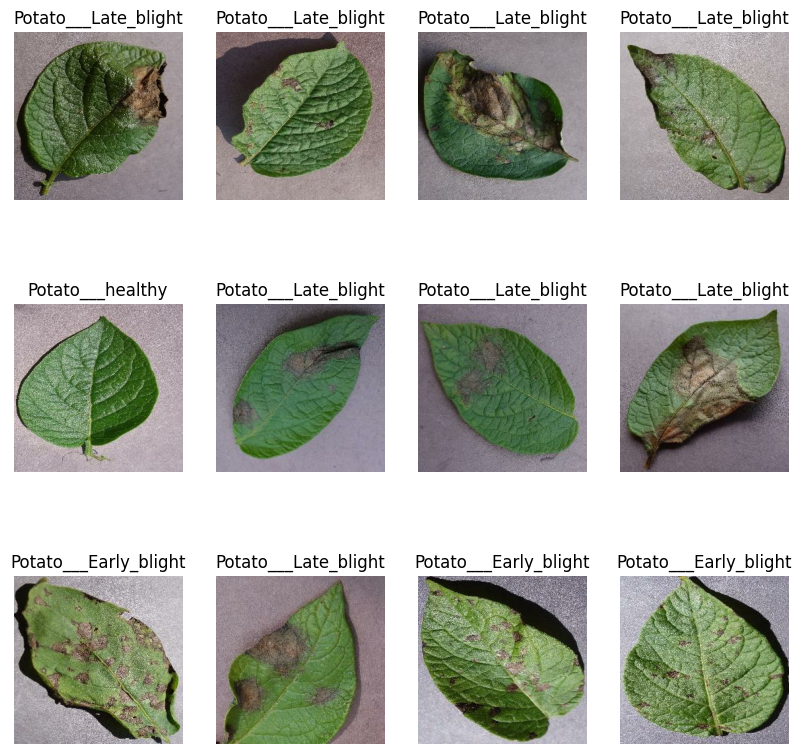

In [7]:
plt.figure(figsize = (10,10))
for image_batch , label_batch in datasets.take(1):
    for i in range(12): 
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")     

Functions to Split DataSet

In [8]:
# training dataset = 80%
# testing dataset = 20 % (10% validation , 10% test)
train_size = 0.8
len(datasets)*train_size

54.400000000000006

In [9]:
train_ds = datasets.take(54)
len(train_ds)

54

In [10]:
test_ds = datasets.skip(54) #arr[54:]
len(test_ds)

14

In [11]:
# calculating the length of validaion set 
val_size = 0.1
len(datasets)*val_size

6.800000000000001

In [12]:
# validation set contains 10% of test dataset
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
# Actual test datasets
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds,train_split = 0.8,val_split = 0.1,test_split =0.1,shuffle = True, shuffle_size = 10000 ):
    ds_size = len(ds)
    if shuffle : 
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(datasets)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

Cache,Shuffle, and Prefetch the Dataset

In [19]:
# watch prefetch video from tensorflow deep learning playlist
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Building the Model

In [20]:
# Creating a layer for resizing & normalization
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [21]:
# data augmentation
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [25]:
# Define the model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Define input shape
    resize_and_rescale,  # Preprocessing layer
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# No need to call model.build()
# Model summary to verify the architecture
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
# Compiling Model
# We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [116]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 801ms/step - accuracy: 0.4505 - loss: 0.9206 - val_accuracy: 0.6146 - val_loss: 0.7869
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 706ms/step - accuracy: 0.6755 - loss: 0.7021 - val_accuracy: 0.7760 - val_loss: 0.5331
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 655ms/step - accuracy: 0.8419 - loss: 0.4014 - val_accuracy: 0.8854 - val_loss: 0.3012
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 671ms/step - accuracy: 0.8886 - loss: 0.2920 - val_accuracy: 0.8958 - val_loss: 0.2830
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 777ms/step - accuracy: 0.9052 - loss: 0.2486 - val_accuracy: 0.8125 - val_loss: 0.4018
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 752ms/step - accuracy: 0.8949 - loss: 0.2574 - val_accuracy: 0.9167 - val_loss: 0.2009
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 646ms/step - accuracy: 0.9171 - loss: 0.1924 - val_accuracy: 0.9323 - val_loss: 0.1427
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 679ms/step - accuracy: 0.9558 - loss: 0.1055 - val_accu

In [117]:
# Scores
# Scores is just a list containing loss and accuracy value
scores  = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.9901 - loss: 0.0553


[0.021928945556282997, 0.99609375]

Plotting the Accuracy and Loss Curves

In [118]:
history

In [119]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [120]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [121]:
type(history.history['loss'])

list

In [122]:
len(history.history['loss'])

50

In [123]:
# show loss for first 5 epochs
history.history['loss'][:5] 

[0.8746821880340576,
 0.6122527122497559,
 0.37200063467025757,
 0.256202757358551,
 0.21516844630241394]

In [124]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

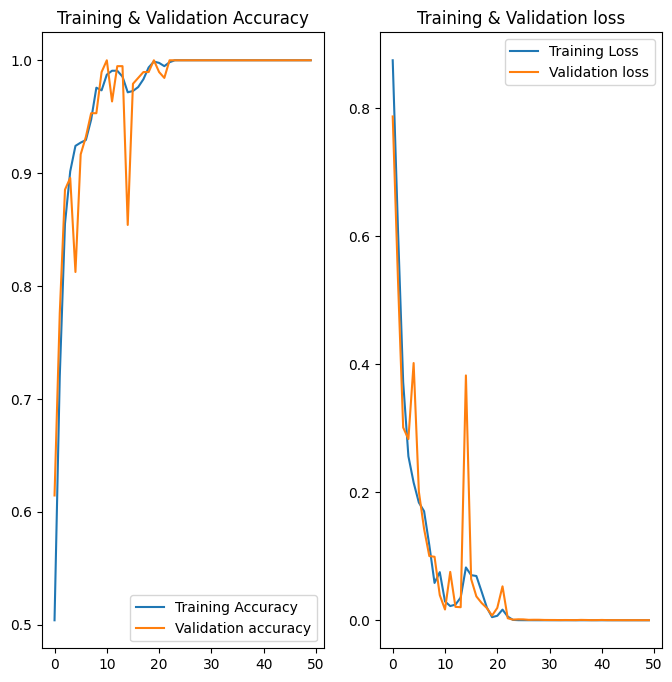

In [125]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = 'Training Loss')
plt.plot(range(EPOCHS),val_loss,label ='Validation loss')
plt.legend(loc='upper right')
plt.title('Training & Validation loss')
plt.show()

Run prediction on sample image

first image  to predict
actual label :  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
predicted label :  Potato___Late_blight


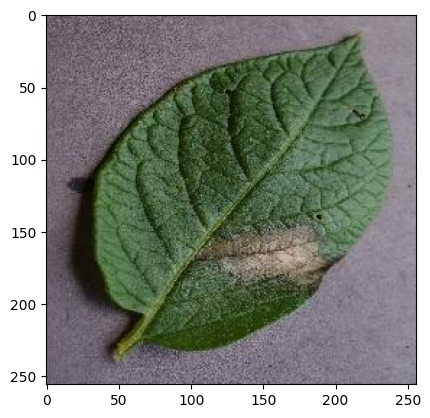

In [126]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image  to predict")
    plt.imshow(first_image)
    print("actual label : ",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])
    

Inference 

In [127]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


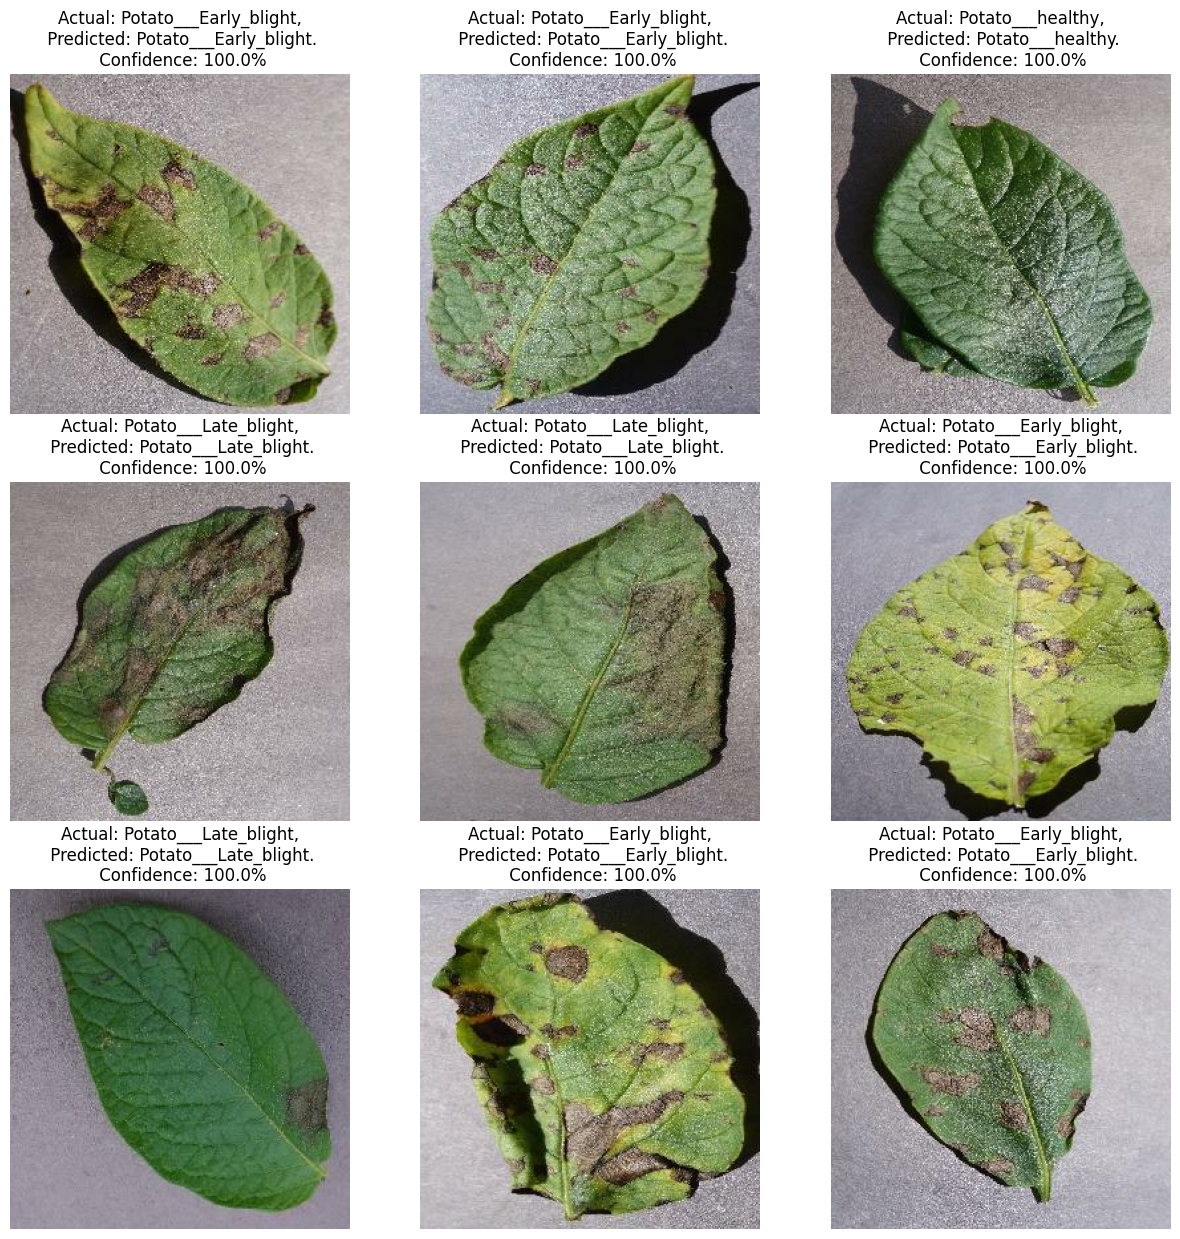

In [128]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Save model

In [129]:
import os
model_version = 1
# Define the base path and the target folder
base_path = "models"
target_folder = "Potato Detection"

# Construct the full path
models_dir = os.path.join(base_path, target_folder)

# Ensure the directory exists
os.makedirs(models_dir, exist_ok=True)

# Get the list of numeric version folders
model_versions = [int(i) for i in os.listdir(models_dir) if i.isdigit()]

# Determine the next model version
model_version = max(model_versions, default=0) + 1

# Save the model with the new version
model.save(os.path.join(models_dir, f"{model_version}.keras"))

print(f"Model saved to: {os.path.join(models_dir, str(model_version))}")


Model saved to: models\Potato Detection\1
